In [17]:
from tqdm import tqdm

import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\minji\AppData\Local\Temp/ipykernel_15044/2875222729.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [4]:
# create data

nPerClust = 100
blur = 1 # how spread out data are from the cluster mean

A = [1, 1]
B = [5, 1]

a = [A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur]
b = [B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur]

labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))

data_np = np.hstack((a, b)).T
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

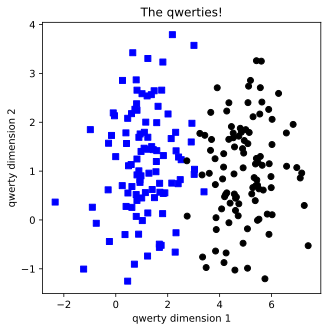

In [5]:
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bs')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [6]:
def createANNmodel(learningRate):
    
    # model architecture
    ANNclassify = nn.Sequential(
        nn.Linear(2,1),
        nn.ReLU(),
        nn.Linear(1,1),
        # nn.Sigmoid()  # final activation unit (not needed b/c we use BCEWithLogitsLoss)
    )
    
    loss_func = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(ANNclassify.parameters(), lr=learningRate)
    
    # model output
    return ANNclassify, loss_func, optimizer

In [8]:
num_epochs = 1000

def train(ANNmodel):
    losses = torch.zeros(num_epochs)
    
    for epoch_i in range(num_epochs):
        
        # forward pass
        y_pred = ANNmodel(data)
        
        # compute loss
        loss = loss_func(y_pred, labels)
        losses[epoch_i] = loss
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # final forward pass
    predictions = ANNmodel(data)
    
    # compute the predictions and report accuracy
    # NOTE: shouldn't it be predictions >.5??
    # 현 함수의 결과값에서는 sigmoid를 씌우지 않음
    # 다시 말해, sigmoid(x) > 0.5가 되려면 x > 0이어야 하므로
    totalacc = 100*torch.mean(((predictions>0) == labels).float())
    
    return losses, predictions, totalacc

Final accuracy: 97.5


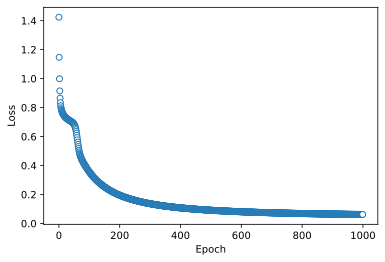

In [9]:
# create everything
ANNclassify, loss_func, optimizer = createANNmodel(0.1)

# run it
losses, predictions, totalacc = train(ANNclassify)

# report accuracy
print(f"Final accuracy: {totalacc}%")

# show the losses
plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=.1)
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

### Now for the experiment

In [14]:
learningrates = np.linspace(.001, .1, 40)

# initialize results output
accByLR = []
allLosses = np.zeros((len(learningrates), num_epochs))

for i, lr in enumerate(learningrates):
    # create and run the model
    ANNclassify, loss_func, optimizer = createANNmodel(lr)
    losses, predictions, totalacc = train(ANNclassify)
    
    # store the results
    accByLR.append(totalacc)
    allLosses[i,:] = losses.detach()

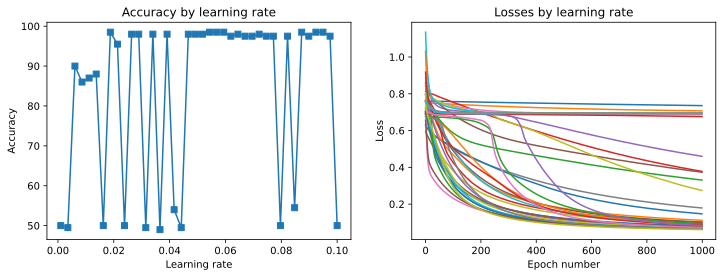

In [15]:
# plot the results
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(learningrates,accByLR,'s-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T) # (1000, 40)
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
ax[1].set_title('Losses by learning rate')
plt.show()

In [16]:
# proportion of runs where the model had at least 70% acc
sum(torch.tensor(accByLR)>70)/len(accByLR)

tensor(0.7250)

### Run a meta-experiment to get more reliable results

100%|██████████| 50/50 [22:44<00:00, 27.29s/it]


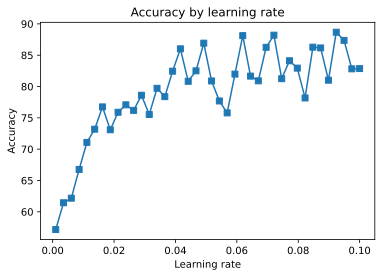

In [19]:
# number of times to iterate through the experiment
numExps = 50

# matrix to store all results
accMeta = np.zeros((numExps, len(learningrates)))

# fewer epochs to reduce computation time
num_epochs = 500

# now for the experiment
for exp_i in tqdm(range(numExps)):
    for i, lr in enumerate(learningrates):
        
        # create and run the model
        ANNclassify, loss_func, optimizer = createANNmodel(lr)
        losses, predictions, totalacc = train(ANNclassify)
        
        # store the results
        accMeta[exp_i, i] = totalacc

# now plot the results, averaged over experiments  
plt.plot(learningrates, np.mean(accMeta, axis=0), 's-')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Accuracy by learning rate')
plt.show()
